In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import sys
import matplotlib.pyplot as plt
from project_lib import Project

In [3]:
!pip install folium
import folium
# import k-means from clustering stage
from sklearn.cluster import KMeans
import urllib, json

     |████████████████████████████████| 102kB 10.3MB/s ta 0:00:01


In [4]:
##SCRAPPING DISTRICS

#define headers for the request
headers = requests.utils.default_headers()
headers.update({"user-agent": "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.87 Safari/537.36"})

#Wikipedia link for the information to scrap
url = "https://en.wikipedia.org/wiki/Districts_of_Madrid"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')

In [5]:
#Finding columns name html style
columns_name = str(soup.center.table.tbody.tr).replace('\n','')

#cleaning tags
columns_string=re.findall('<th>(.+?)<',columns_name)

columns = [list(columns_string)[1],list(columns_string)[3]]
#Transform in a Series to create data frame
columns_name = pd.Series(list(columns))

#finding dataframe values
values = str(soup.center.find_all("td")).replace('\n','')
values = re.findall('>(.+?)</td>',values)

#finding Neighbourhood clean name
neigh = []
for value in values:
    if len(re.findall('>(.+?)</a>',str(value)))<1:
        neigh.append(value)
    else:
        a = re.findall('>(.+?)<',str(value)) #result type is a list
        neigh.append(a[0])

In [6]:
#Define two empty list to get District Name and population
d=[]
h1=[]
h2=[] #h1 will return a nest list, to extract the population in just one list
i=0

for i in range(int(len(neigh)/7)):
    if i==0:
        d.append(neigh[i+1])
        h1.append(re.findall('>(.+?)</span>',str(neigh[i+3])))
        h2.append(int(str(h1[i][i]).replace(',','')))
    else:
        d.append(neigh[i*7+1])
        h1.append(re.findall('>(.+?)</span>',neigh[i*7+3]))
        h2.append(int(str(h1[i][0]).replace(',','')))

        #Creating the df wich contains info about Madrid districts

dicti = {'District Name':d,
         'District Population':h2    
}

mddist = pd.DataFrame(dicti)
mddist


,District Name,District Population
0,Centro,131928
1,Arganzuela,151965
2,Retiro,118516
3,Salamanca,143800
4,Chamartín,143424
5,Tetuán,153789
6,Chamberí,137401
7,Fuencarral-El Pardo,238756
8,Moncloa-Aravaca,116903
9,Latina,233808


In [7]:
#Conecting with Comunidad de Madrid official data to get neighborhoods

#Wikipedia link for the information to scrap
url2 = "https://datos.comunidad.madrid/catalogo/dataset/91857345-056b-4aa7-96f5-6310dac619bf/resource/b9cf6d43-79b0-400e-82de-ca00de21f6bb/download/barrios_municipio_madrid.json"
req2 = requests.get(url2, verify=False)
#With the mdjson and District name We can find the Neighborhood
mdjson = req2.json()

mdjson
#mdjson has spaces leading and ending in barrio_nombre and distrito_nombre, let's clean that


for i in range(len(mdjson['data'])):
        for j in mdjson['data'][i]:
            if type(mdjson['data'][i][j])==str:
                mdjson['data'][i][j]=mdjson['data'][i][j].strip()


/opt/conda/envs/Python36/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [8]:
#Now we create 2 empty list, to append distrito_nombre(District Name) & barrio_nombre(Neighborhood) 
#also we use madrid['District Name'] to go through the json


d = [] #district
n = [] #neighborhood
i=0
j=0

for j in range (len(mdjson['data'])):
    if mdjson['data'][j]['distrito_nombre']=='Tetuan':
        d.append('Tetuán')
        n.append(mdjson['data'][j]['barrio_nombre'])
    else:
        d.append(mdjson['data'][j]['distrito_nombre'])
        n.append(mdjson['data'][j]['barrio_nombre'])

#lets create a 2nd df with the new info

mdneigh = pd.DataFrame({'District Name':d,
                       'Neighborhood':n
})
mdneigh

,District Name,Neighborhood
0,Centro,Palacio
1,Centro,Embajadores
2,Centro,Cortes
3,Centro,Justicia
4,Centro,Universidad
5,Centro,Sol
6,Arganzuela,Imperial
7,Arganzuela,Las Acacias
8,Arganzuela,La Chopera
9,Arganzuela,Legazpi


In [9]:
#Now lets join df madrid with mdneigh 
madrid = pd.merge(mdneigh,mddist,on='District Name')
madrid.head(10)
#Extract data from RentaxNeighborhood.csv from github repository
madridrent = pd.read_csv('https://raw.githubusercontent.com/cazuaje27/BattleofNeighborhoods/master/RentaxNeighborhood.csv', sep=';',skiprows=2,header=1)
madridrent.rename(columns={'Territorio':'Neighborhood','Renta neta media por hogar':'Net Income by Home'}, inplace=True)


#Merge to get all Rent in madrid dataframe

madrid = madrid.merge(madridrent, on=['Neighborhood'])
madrid.drop(axis=1, columns=['Orden','Cod. Territorio'], inplace=True)
madrid.head(10)

,District Name,Neighborhood,District Population,Net Income by Home
0,Centro,Palacio,131928,34.676
1,Centro,Embajadores,131928,26.000
2,Centro,Cortes,131928,34.953
3,Centro,Justicia,131928,40.315
4,Centro,Universidad,131928,30.702
5,Centro,Sol,131928,30.936
6,Arganzuela,Imperial,151965,41.951
7,Arganzuela,Las Acacias,151965,44.669
8,Arganzuela,La Chopera,151965,31.934
9,Arganzuela,Legazpi,151965,48.935


In [10]:
#Let's read the house price for m2 in Madrid by Neighborhood
#ph = price house
ph = pd.read_excel('https://github.com/cazuaje27/BattleofNeighborhoods/raw/master/HousingPrice2019%20(1).xls',sep='/t', skiprows=7)
ph.drop(axis=1, columns=['Unnamed: 0'], inplace=True)
ph.rename(columns={'Unnamed: 1':'Neighborhood', 'Unnamed: 2':'House Price 2019 €/m2','Unnamed: 3':'House Price 2018 €/m2'}, inplace=True)
ph.dropna(inplace=True)
ph['Neighborhood']=ph['Neighborhood'].str.strip().str.strip('0123456789.').str.strip()

#Now merge the data with madrid df
madrid = madrid.merge(ph, on=['Neighborhood'], how='inner')

In [11]:
#Defining an empty list to get the HousePrice Growth for each Neighborhood
hpg = []

for i in range(len(madrid['Neighborhood'])):
    if madrid['House Price 2018 €/m2'].loc[i] != 0:
        hpg.append(float("{:.2f}".format(madrid['House Price 2019 €/m2'].loc[i]/madrid['House Price 2018 €/m2'].loc[i]*100-100)))
    else:
        hpg.append(0)

madrid['House Price Growth %'] = hpg


In [12]:
#Reading the Madrid geojson to make a map using folium

urlgeojson=('https://raw.githubusercontent.com/cazuaje27/BattleofNeighborhoods/master/Madrid.geojson')
mdgeojson = requests.get(urlgeojson).json()

#Lets check if the District & Neighborhood have the same format that we already have
d2=[]
n2=[]
for i in range(len(mdgeojson['features'])):
    d2.append(mdgeojson['features'][i]['properties']['NOMDIS'])
    n2.append(mdgeojson['features'][i]['properties']['Name'])

mdmap=pd.DataFrame({'District Name':d2,
                    'Neighborhood':n2
                   })
mdmap.describe()

,District Name,Neighborhood
count,131,131
unique,21,131
top,Ciudad Lineal,Las Acacias
freq,9,1


In [13]:
#Lets change format for District Name
#first we define two series with the unique values of each column
mapdist = mdmap['District Name'].sort_values().unique()
maddist = madrid['District Name'].sort_values().unique()
#empty list for district name corrected
d3=[]

for j,k in zip(range(len(mapdist)),range(len(maddist))):
    for i in range(len(mdgeojson['features'])):
        if mdgeojson['features'][i]['properties']['NOMDIS']==mapdist[j]:
            mdgeojson['features'][i]['properties']['NOMDIS']=maddist[k]

#fill the empty list with the right names                   
for i in range(len(mdgeojson['features'])):
    d3.append(mdgeojson['features'][i]['properties']['NOMDIS'])

mdmap = pd.DataFrame({'District Name':d3,
                    'Neighborhood':n2
                   })


In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
#Now let use google cloud geocoding API to get coordinates from Madrid and its Neighborhood
#Define url to make the request
geocoding_url="https://maps.googleapis.com/maps/api/geocode/json?address="
consult_madrid = "{city},+Spain&key={key}".format(city='Madrid',key=ApiKey)
geocoding_madrid = requests.get(geocoding_url+consult_madrid)
#Json results
geocodingjson = geocoding_madrid.json()
#Now we extract latitude and longitude from Madrid to make the Map using folium
mdlat = geocodingjson['results'][0]['geometry']['location']['lat']
mdlng = geocodingjson['results'][0]['geometry']['location']['lng']

In [16]:

consult_neigh = "{neigh},+{district},+Madrid,+Spain&key={key}".format(neigh=madrid['Neighborhood'][2], district=madrid['District Name'][2], key=ApiKey)
geocoding_neigh = requests.get(geocoding_url+consult_neigh)
geoneighjson=geocoding_neigh.json()
neighlat = geoneighjson['results'][0]['geometry']['location']['lat']
neighlng = geoneighjson['results'][0]['geometry']['location']['lng']


In [17]:
#Finding every Neighborhood coordinates for the maps.

neigh_lat = []
neigh_lon = []

for i in range(len(madrid['Neighborhood'])):
    consult_neigh = "{neigh},+{district},+Madrid,+Spain&key={key}".format(neigh=madrid['Neighborhood'][i], district=madrid['District Name'][i], key=ApiKey)
    geocoding_neigh = requests.get(geocoding_url+consult_neigh)
    geoneighjson=geocoding_neigh.json()
    neigh_lat.append(geoneighjson['results'][0]['geometry']['location']['lat'])
    neigh_lon.append(geoneighjson['results'][0]['geometry']['location']['lng'])
    
    
madrid['Neighborhood Latitude']=neigh_lat
madrid['Neighborhood Longitude']=neigh_lon

In [89]:
#Making the first Choropleth Map for the Analysis District Population in Madrid
madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)

madridPopulation = folium.Choropleth(geo_data=mdgeojson,
                  name='choropleth',
                  data=madrid,
                  columns=['District Name', 'District Population'],
                  key_on='feature.properties.NOMDIS',
                  fill_color='YlOrRd',
                  fill_opacity=0.5,
                  line_opacity=0.2,
                  legend_name='District Population',
                  threshold_scale = [0,50000,100000,150000,200000,250000]

)


madridPopulation.add_to(madridmap)
madridPopulation.geojson.add_child(folium.features.GeoJsonTooltip(['Name','NOMDIS'],labels=False))
html_madridPopulation = madridPopulation.get_root().render()
project.save_data(file_name='madrid_population.txt',data=html_madridPopulation,set_project_asset=True, overwrite=True)
madridmap

In [19]:
#2nd Map for the Analysis, Net Income per Neighborhood

madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)
madridNetIncome = folium.Choropleth(geo_data=mdgeojson,
                  name='choropleth',
                  data=madrid,
                  columns=['Neighborhood', 'Net Income by Home'],
                  key_on='feature.properties.Name',
                  fill_color='BuGn',
                  nan_fill_color = 'white',                  
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='Net Income by Home (x1000)',
                  threshold_scale = [0,20,40,60,80,100,120]
                  

)

madridNetIncome.add_to(madridmap)
madridNetIncome.geojson.add_child(folium.features.GeoJsonTooltip(['Name','NOMDIS'],labels=False))
html_madridIncome = madridIncome.get_root().render()
project.save_data(file_name='madrid_Income.txt',data=html_madridIncome,set_project_asset=True, overwrite=True)
madridmap

In [20]:
#3rd Map for the Analysis, House Price in 2019 €/m2

madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)
madridHouse2019 = folium.Choropleth(geo_data=mdgeojson,
                  name='choropleth',
                  data=madrid,
                  columns=['Neighborhood', 'House Price 2019 €/m2'],
                  key_on='feature.properties.Name',
                  fill_color='PuBuGn',
                  nan_fill_color = 'white',                  
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='House Price in 2019 Euro/m2',
                  threshold_scale = [0,1000,2000,3000,4000,5000,6000,7500,8500]
)

madridHouse2019.add_to(madridmap)
madridHouse2019.geojson.add_child(folium.features.GeoJsonTooltip(['Name','NOMDIS'],labels=False))
html_madridHouse = madridHouse.get_root().render()
project.save_data(file_name='madrid_house.txt',data=html_madridHouse,set_project_asset=True, overwrite=True)
madridmap

In [21]:
#Lets Create a Map with the House Price Growth of Madrid

madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)
madridHousePGrowth = folium.Choropleth(geo_data=mdgeojson,
                  name='choropleth',
                  data=madrid,
                  columns=['Neighborhood', 'House Price Growth %'],
                  key_on='feature.properties.Name',
                  fill_color='PuBuGn',
                  nan_fill_color = 'white',                  
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='House Price in 2019 Euro/m2',
                  #threshold_scale = [0,1000,2000,3000,4000,5000,6000,7500,8500]
)

madridHousePGrowth.add_to(madridmap)
madridHousePGrowth.geojson.add_child(folium.features.GeoJsonTooltip(['Name','NOMDIS'],labels=False))
html_madridGrowth = madridHousePGrowth.get_root().render()
project.save_data(file_name='madrid_Growth.txt',data=html_madridGrowth,set_project_asset=True, overwrite=True)
madridmap

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
#Now start the neighborhood investigation using Foursquare

#Funtion to scrap the foursquare information, I going to include PostalCode and Borough. Because many neighborhood has the same location of one PostalCode.

LIMIT = 100

def getNearbyVenues(district, neigh, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for district, neigh, lat, lng in zip(district, neigh, latitudes, longitudes):
        #print('{}: {}'.format(district,neigh))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            district,
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District Name',
                  'Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [24]:
#We use the funtion created above to get the venues from Madrid
madrid_venues = getNearbyVenues(madrid['District Name'], madrid['Neighborhood'], madrid['Neighborhood Latitude'], madrid['Neighborhood Longitude'], radius=700)
madrid_venues.groupby(['District Name','Neighborhood']).count()

Latitude  Longitude  Venue  \
District Name       Neighborhood                                               
Arganzuela          Atocha                              90         90     90   
                    Delicias                            79         79     79   
                    Imperial                            47         47     47   
                    La Chopera                          86         86     86   
                    Las Acacias                         98         98     98   
                    Legazpi                             40         40     40   
                    Palos de Moguer                    100        100    100   
Barajas             Aeropuerto                          15         15     15   
                    Alameda de Osuna                    25         25     25   
                    Casco Histórico de Barajas          36         36     36   
                    Corralejos                          17         17     17   
Carabanchel         Abrantes                             5          5      5   
                    Buenavista                          14         14     14   
                    Comillas                            40         40     40   
                    Opañel                              26         26     26   
                    Puerta Bonita                       20         20     20   
                    San Isidro                          15         15     15   
                    Vista Alegre                        25         25     25   
Centro              Cortes                             100        100    100   
                    Embajadores                        100        100    100   
                    Justicia                           100        100    100   
                    Palacio                             96         96     96   
                    Sol                                100        100    100   
                    Universidad                        100        100    100   
Chamartín           Castilla                            39         39     39   
                    Ciudad Jardín                       93         93     93   
                    El Viso                             90         90     90   
                    Hispanoamérica                     100        100    100   
                    Nueva España                        64         64     64   
                    Prosperidad                        100        100    100   
...                                                    ...        ...    ...   
San Blas-Canillejas Amposta                              7          7      7   
                    Arcos                               20         20     20   
                    Canillejas                          24         24     24   
                    El Salvador                         43         43     43   
                    Hellín                               5          5      5   
                    Rejas                               22         22     22   
                    Rosas                               21         21     21   
                    Simancas                            69         69     69   
Tetuán              Almenara                            49         49     49   
                    Bellas Vistas                       77         77     77   
                    Berruguete                          49         49     49   
                    Castillejos                         93         93     93   
                    Cuatro Caminos                      90         90     90   
                    Valdeacederas                       12         12     12   
Usera               Almendrales                         27         27     27   
                    Moscardó                            52         52     52   
                    Orcasitas                            7          7      7   
                    Orcasur                       

In [25]:
#Now we create a dataframe with the venues as columns
madrid_venuescat = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# adding District Name and Neighborhood column back to dataframe
#We change the name of the columns neighborhood to neighbohoods because there is one venue with the same name
madrid_venuescat[['District Name','Neighborhoods']] = madrid_venues[['District Name','Neighborhood']] 

# move District Name and Neighborhood column to the first column
fixed_columns = [madrid_venuescat.columns[-2]]+ [madrid_venuescat.columns[-1]] +list(madrid_venuescat.columns[:-2])
madrid_venuescat = madrid_venuescat[fixed_columns]

madrid_venuescat.head()

,District Name,Neighborhoods,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Centro,Palacio,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Centro,Palacio,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Centro,Palacio,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Centro,Palacio,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Centro,Palacio,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#Now the dataframe group the repetion of each venue category by neighborhoods
madrid_grouped = madrid_venuescat.groupby(['District Name','Neighborhoods']).mean().reset_index()
madrid_grouped

,District Name,Neighborhoods,Accessories Store,Adult Boutique,Airport,Airport Lounge,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Arganzuela,Atocha,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
1,Arganzuela,Delicias,0.00,0.00,0.000000,0.000000,0.000000,0.012658,0.000000,0.025316,...,0.0,0.000000,0.00,0.000000,0.000000,0.012658,0.000000,0.00,0.0,0.000000
2,Arganzuela,Imperial,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
3,Arganzuela,La Chopera,0.00,0.00,0.000000,0.000000,0.000000,0.011628,0.000000,0.023256,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
4,Arganzuela,Las Acacias,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.010204,0.00,0.000000,0.000000,0.000000,0.010204,0.00,0.0,0.000000
5,Arganzuela,Legazpi,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.0,0.000000,0.00,0.000000,0.000000,0.025000,0.000000,0.00,0.0,0.000000
6,Arganzuela,Palos de Moguer,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.0,0.010000,0.00,0.000000,0.000000,0.000000,0.010000,0.01,0.0,0.000000
7,Barajas,Aeropuerto,0.00,0.00,0.000000,0.266667,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
8,Barajas,Alameda de Osuna,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000
9,Barajas,Casco Histórico de Barajas,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,...,0.0,0.000000,0.00,0.000000,0.000000,0.027778,0.000000,0.00,0.0,0.000000


In [27]:
#Lets create a funtion to get the most common venues for each group.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District Name','Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[['District Name','Neighborhoods']] = madrid_grouped[['District Name','Neighborhoods']]

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,District Name,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arganzuela,Atocha,Spanish Restaurant,Restaurant,Hotel,Bakery,Museum,Bar,Café,Italian Restaurant,Train Station,Grocery Store
1,Arganzuela,Delicias,Spanish Restaurant,Tapas Restaurant,Bakery,Beer Garden,Gym / Fitness Center,Plaza,Grocery Store,Farmers Market,Art Gallery,Restaurant
2,Arganzuela,Imperial,Spanish Restaurant,Park,Hotel,Gym / Fitness Center,Grocery Store,Pizza Place,Tapas Restaurant,Beer Garden,Brewery,Theater
3,Arganzuela,La Chopera,Spanish Restaurant,Coffee Shop,Tapas Restaurant,Gym,Grocery Store,Bakery,Restaurant,Burger Joint,Mediterranean Restaurant,Park
4,Arganzuela,Las Acacias,Spanish Restaurant,Tapas Restaurant,Restaurant,Bar,Art Gallery,Indie Theater,Theater,Plaza,Pizza Place,Market
5,Arganzuela,Legazpi,Bar,Supermarket,Spanish Restaurant,Dessert Shop,Tapas Restaurant,Restaurant,Argentinian Restaurant,Café,Bistro,Theater
6,Arganzuela,Palos de Moguer,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Gym / Fitness Center,Indie Theater,Café,Beer Garden,Market,Art Gallery
7,Barajas,Aeropuerto,Airport Lounge,Sporting Goods Shop,Coffee Shop,Spanish Restaurant,Fast Food Restaurant,Cafeteria,Sandwich Place,Duty-free Shop,Breakfast Spot,Discount Store
8,Barajas,Alameda de Osuna,Hotel,Smoke Shop,Chinese Restaurant,Spanish Restaurant,Bar,Park,Beer Garden,Tennis Court,Scenic Lookout,Tapas Restaurant
9,Barajas,Casco Histórico de Barajas,Hotel,Spanish Restaurant,Restaurant,Argentinian Restaurant,Tapas Restaurant,Grocery Store,Pizza Place,Coffee Shop,Sandwich Place,Fast Food Restaurant


In [29]:
#Lets Create Cluster Using information 


madrid_grouped_clustering = madrid_grouped.drop(['Neighborhoods','District Name'], axis=1)

# run k-means clustering
kclusters = 5

#Lets run the model
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3,
       0, 4, 4, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       0, 0, 2, 0, 0, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 0, 3, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0,
       4, 0, 3, 3, 3, 4, 3, 3, 4, 3, 3, 0, 3, 3, 3, 0, 3], dtype=int32)

In [30]:

#Lets include the Clusters with all the information
madrid_merged = madrid[['District Name','Neighborhood','Neighborhood Latitude','Neighborhood Longitude']]
#madrid_merged.drop(axis=0, index=126,inplace=True)

# add clustering labels
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_



# merge madrid_grouped with madrid_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index(['District Name','Neighborhoods']), on=['District Name','Neighborhood'], how='inner')


madrid_merged['Cluster Labels'].value_counts()

0    71
3    46
4     8
2     1
1     1
Name: Cluster Labels, dtype: int64

In [31]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


# create a map with the clusters
madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Neighborhood Latitude'], madrid_merged['Neighborhood Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(madridmap)
       
html_madridClusters = madridmap.get_root().render()
project.save_data(file_name='madrid_Cluster.txt',data=html_madridClusters,set_project_asset=True, overwrite=True)
madridmap

In [32]:
df1 = madrid_venues.groupby(['Venue Category']).count().reset_index()

#Using madrid_venues We get Madrid Top 5 Venues Categories
Top5Md = df1.sort_values(['District Name'],ascending=False).head(5)
Top5Md.rename(columns={'District Name':'N° Places'},inplace=True)
Top5Md.reset_index(inplace=True)
Top5Md.drop(axis=1,columns=['index','Neighborhood','Latitude','Longitude','Venue','Venue Latitude', 'Venue Longitude'], inplace=True)
Top5Md

,Venue Category,N° Places
0,Spanish Restaurant,559
1,Restaurant,322
2,Tapas Restaurant,244
3,Bar,243
4,Hotel,174


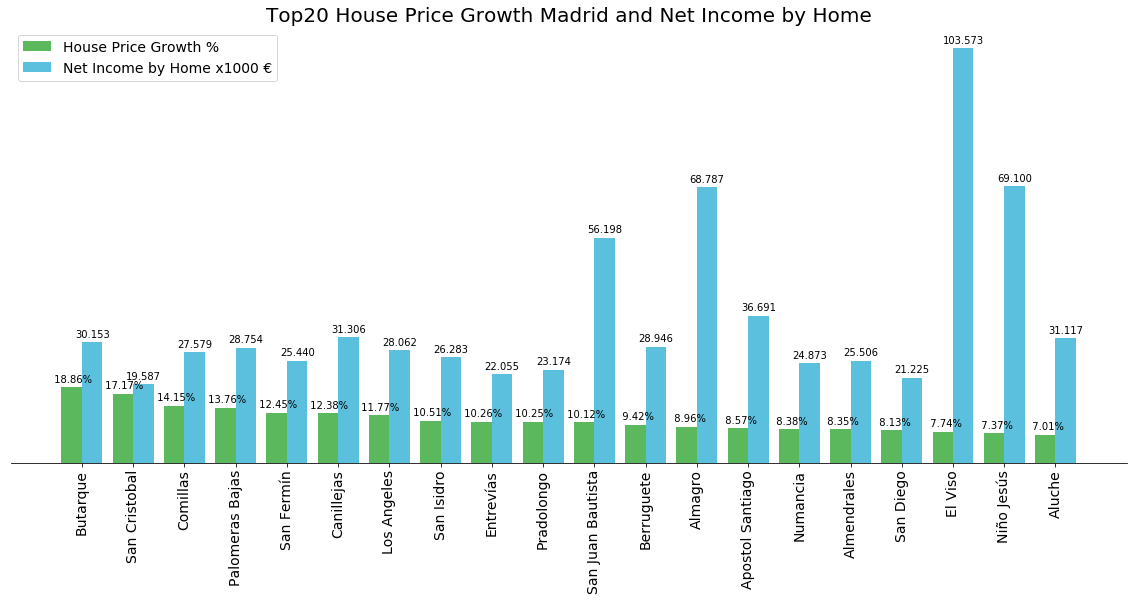

In [33]:
#Lets Check the TOP 20 Neighborhood Housing Price Growth
Top20Growth = madrid.sort_values(by=['House Price Growth %'],ascending=[False]).head(20)

HpG = list(Top20Growth['House Price Growth %'])
NiH = list(Top20Growth['Net Income by Home'])
ind = np.arange(len(Top20Growth['Neighborhood']))
width = 0.8

fig = plt.figure(figsize=(20,8))

ax = fig.subplots()

VI1 = ax.bar(ind-width/4, HpG, width/2, color='#5cb85c', label = 'House Price Growth %')
NI1 = ax.bar(ind+width/4, NiH,width/2, color='#5bc0de', label ='Net Income by Home x1000 €')


ax.tick_params('y', grid_alpha=0)

# Add label in each bar with % symbol
def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:6.2f}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height), fontsize=10,
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

# Add label in each bar without % symbol
def autolabel2(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:6.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height), fontsize=10,
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

        
autolabel(VI1,'center')
autolabel2(NI1,'center')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Top20 House Price Growth Madrid and Net Income by Home', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(Top20Growth['Neighborhood'], fontsize=14, rotation='vertical')


ax.set_yticklabels([0,10,20,30,40,50,60], visible=False)
ax.yaxis.set_ticks_position(position='none')

ax.get_geometry()
ax.legend(fontsize=14)


In [83]:
#Now lets get the Top5 Venue of Each Neighborhood.
df2 = madrid_venues.groupby(['District Name','Neighborhood','Venue Category']).agg({
    'Venue':pd.Series.nunique
})
df2.rename(columns={'Venue':'N° Venues'}, inplace=True)

df2.sort_values(['District Name','Neighborhood','N° Venues'],ascending=[True,True,False],inplace=True)
Top5VenuesNeigh = df2.groupby(level=1).head()
Top5VenuesNeigh.head()

N° Venues
District Name Neighborhood Venue Category               
Arganzuela    Atocha       Spanish Restaurant          9
                           Restaurant                  8
                           Hotel                       6
                           Museum                      5
                           Bakery                      4

In [84]:
#Now from the bar chart Top20 House Price Growth Madrid and Net Income by Home, 
#we get a good combination from Price Growth and Net Income by Home. Lets reduce to 5 Neighborhoods

filtertop5 = ['San Juan Bautista', 'Almagro','Apostol Santiago', 'El Viso','Niño Jesús']
Top5VenuesNeigh.reset_index(inplace=True)
Top5Neigh = pd.DataFrame(columns=Top5VenuesNeigh.columns,index=[0])
for item in filtertop5:
    Top5Neigh = Top5Neigh.append(Top5VenuesNeigh[Top5VenuesNeigh['Neighborhood']==item],ignore_index=True)

Top5Neigh.sort_values(['District Name','Neighborhood','N° Venues'],ascending=[True,True,False],inplace=True)
Top5Neigh.drop(axis=0,index=0,inplace=True)
Top5Neigh.reset_index(inplace=True)
Top5Neigh.drop(axis=1,columns='index',inplace=True)
Top5Neigh

,District Name,Neighborhood,Venue Category,N° Venues
0,Chamartín,El Viso,Spanish Restaurant,13
1,Chamartín,El Viso,Burger Joint,6
2,Chamartín,El Viso,Plaza,5
3,Chamartín,El Viso,Soccer Stadium,5
4,Chamartín,El Viso,Coffee Shop,4
5,Chamberí,Almagro,Restaurant,14
6,Chamberí,Almagro,Spanish Restaurant,9
7,Chamberí,Almagro,Mediterranean Restaurant,5
8,Chamberí,Almagro,Plaza,5
9,Chamberí,Almagro,Tapas Restaurant,5


In [88]:
#Lets Merge the Top5Neigh dataframe with Madrid dataframe to finally get all the data to the final analysis
Top5 = Top5Neigh.drop(axis=1,columns=['Venue Category','N° Venues'])
Top5 = Top5.merge(madrid, how='left', on=['District Name','Neighborhood'])
Top5.drop_duplicates(inplace=True)
Top5.sort_values(['House Price Growth %','Net Income by Home'],ascending=[False,False],inplace=True)
Top5.drop(axis=1, columns=['District Population','House Price 2019 €/m2','House Price 2018 €/m2'], inplace=True)
Top5

,District Name,Neighborhood,Net Income by Home,House Price Growth %,Neighborhood Latitude,Neighborhood Longitude
10,Ciudad Lineal,San Juan Bautista,56.198,10.12,40.449584,-3.661156
5,Chamberí,Almagro,68.787,8.96,40.433862,-3.695287
15,Hortaleza,Apostol Santiago,36.691,8.57,40.477839,-3.659789
0,Chamartín,El Viso,103.573,7.74,40.449021,-3.686681
20,Retiro,Niño Jesús,69.100,7.37,40.410161,-3.676716


In [93]:
#Lets Create the finally Map with the Top5 Neighborhoods

madridmap = folium.Map(location=[mdlat,mdlng], zoom_start=11)
madridTop5 = folium.Choropleth(geo_data=mdgeojson,
                  name='choropleth',
                  data=Top5,
                  columns=['Neighborhood', 'House Price Growth %'],
                  key_on='feature.properties.Name',
                  fill_color='PuBuGn',
                  nan_fill_color = 'white',                  
                  fill_opacity=0.7,
                  line_opacity=0.5,
                  legend_name='House Price in 2019 Euro/m2',
                  threshold_scale = [0,2,4,6,8,10,12]
)

madridTop5.add_to(madridmap)
madridTop5.geojson.add_child(folium.features.GeoJsonTooltip(['Name','NOMDIS'],labels=False))
html_madridTop5 = madridTop5.get_root().render()
project.save_data(file_name='madrid_Top5.txt',data=html_madridTop5,set_project_asset=True, overwrite=True)
madridmap

,Neighborhood,Cluster Labels
0,Palacio,0
1,Embajadores,0
2,Cortes,0
3,Justicia,0
4,Universidad,0
5,Sol,0
6,Imperial,0
7,Las Acacias,0
8,La Chopera,0
9,Legazpi,0
